In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from file_parsers import parse_badges, parse_posts, parse_comments, parse_users,\
    parse_posthistory, parse_postlinks, parse_votes, parse_tags

In [65]:
import seaborn as sns

In [5]:
spark = SparkSession.builder \
    .appName('StackExchange') \
    .master('local[*]') \
    .getOrCreate()
sc = spark.sparkContext

# Data Loading

In [6]:
stack = '/home/piotr/big_data/archive.org/download/stackexchange/'
#subject = 'meta.stackoverflow.com/'
subject = 'gardening.stackexchange.com/'
path = stack + subject

In [7]:
badges = parse_badges(sc, path + 'Badges.xml')
posts = parse_posts(sc, path + 'Posts.xml')
comments = parse_comments(sc, path + 'Comments.xml')
users = parse_users(sc, path + 'Users.xml')
posthistory = parse_posthistory(sc, path + 'PostHistory.xml')
postlinks = parse_postlinks(sc, path + 'PostLinks.xml')
votes = parse_votes(sc, path + 'Votes.xml')
tags = parse_tags(sc, path + 'Tags.xml')

# Posts

In [8]:
posts.printSchema()

root
 |-- Id: float (nullable = true)
 |-- PostTypeId: float (nullable = true)
 |-- ParentId: float (nullable = true)
 |-- AcceptedAnswerId: float (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- ViewCount: float (nullable = true)
 |-- Body: string (nullable = true)
 |-- OwnerUserId: float (nullable = true)
 |-- LastEditorUserId: float (nullable = true)
 |-- LastEditorDisplayName: string (nullable = true)
 |-- LastEditDate: string (nullable = true)
 |-- LastActivityDate: string (nullable = true)
 |-- CommunityOwnedDate: string (nullable = true)
 |-- ClosedDate: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- AnswerCount: float (nullable = true)
 |-- CommentCount: float (nullable = true)
 |-- FavoriteCount: float (nullable = true)



In [9]:
posts_filtered = posts.select(col('Id').cast('integer'), \
                             col('PostTypeId').cast('integer'), \
                             col('ParentId').cast('integer'), \
                             col('CreationDate').cast('timestamp'),
                             col('AnswerCount').cast('integer'))

In [10]:
posts_filtered.head(3)

[Row(Id=1, PostTypeId=1, ParentId=None, CreationDate=datetime.datetime(2011, 6, 8, 18, 35, 50, 450000), AnswerCount=5),
 Row(Id=2, PostTypeId=1, ParentId=None, CreationDate=datetime.datetime(2011, 6, 8, 18, 37, 12, 493000), AnswerCount=2),
 Row(Id=3, PostTypeId=1, ParentId=None, CreationDate=datetime.datetime(2011, 6, 8, 18, 37, 45, 593000), AnswerCount=3)]

In [11]:
posts_filtered.groupBy('PostTypeId').count().show()

+----------+-----+
|PostTypeId|count|
+----------+-----+
|         1|11008|
|         5|  335|
|         4|  335|
|         7|    2|
|         2|17451|
+----------+-----+



## ile pytań bez odpowiedzi

In [12]:
posts_filtered.filter(col('AnswerCount')==0).count()

889

## rozkład czasu pierwszej odpowiedzi

In [13]:
questions = posts_filtered.filter(col('PostTypeId')==1)
answers = posts_filtered.filter(col('PostTypeId')==2)

In [14]:
questions.show(5)

+---+----------+--------+--------------------+-----------+
| Id|PostTypeId|ParentId|        CreationDate|AnswerCount|
+---+----------+--------+--------------------+-----------+
|  1|         1|    null|2011-06-08 18:35:...|          5|
|  2|         1|    null|2011-06-08 18:37:...|          2|
|  3|         1|    null|2011-06-08 18:37:...|          3|
|  4|         1|    null|2011-06-08 18:37:...|          3|
|  6|         1|    null|2011-06-08 18:39:...|          5|
+---+----------+--------+--------------------+-----------+
only showing top 5 rows



In [15]:
answers.show(5)

+---+----------+--------+--------------------+-----------+
| Id|PostTypeId|ParentId|        CreationDate|AnswerCount|
+---+----------+--------+--------------------+-----------+
|  5|         2|       1|2011-06-08 18:38:...|       null|
|  9|         2|       1|2011-06-08 18:39:...|       null|
| 11|         2|       4|2011-06-08 18:40:...|       null|
| 12|         2|       1|2011-06-08 18:40:...|       null|
| 14|         2|       2|2011-06-08 18:41:...|       null|
+---+----------+--------+--------------------+-----------+
only showing top 5 rows



In [47]:
from pyspark.sql import functions as F
first_answers = answers.groupBy('ParentId').agg(F.min(answers.CreationDate))
first_answers.show(5)

+--------+--------------------+
|ParentId|   min(CreationDate)|
+--------+--------------------+
|     148|2011-06-08 23:50:...|
|     463|2011-06-13 23:48:...|
|    1088|2011-07-03 13:31:...|
|    1342|2011-07-21 05:30:...|
|    1591|2011-08-05 23:49:...|
+--------+--------------------+
only showing top 5 rows



In [62]:
#cos aliasami
from pyspark.sql.functions import unix_timestamp
df_as1 = questions.alias("questions")
df_as2 = first_answers.alias("first_answers")
joined = df_as1.join(df_as2, col("questions.Id") == col("first_answers.ParentId"), 'inner')
questions_time = joined.select(col('Id'), col('CreationDate'), col('min(CreationDate)'))
diff = questions_time.withColumn('diff', (unix_timestamp(col('min(CreationDate)'))-unix_timestamp(col('CreationDate')))/60)
first_answer_time = diff.select(col('Id'), col('diff'))
first_answer_time_pandas = first_answer_time.toPandas()

In [77]:
first_answer_time_pandas[first_answer_time_pandas['diff']<1]['diff']

688     0.000000
1576    0.000000
1872    0.000000
2240    0.000000
3801    0.383333
3860    0.000000
4700    0.000000
4897    0.450000
5152    0.000000
5257    0.000000
5399    0.000000
5434    0.000000
5672    0.000000
6224    0.000000
6326    0.000000
6429    0.016667
6564    0.000000
6764    0.000000
7017    0.000000
7542    0.000000
7807    0.000000
8073    0.000000
8107    0.000000
8169    0.000000
9482    0.000000
9645    0.000000
9953    0.000000
Name: diff, dtype: float64

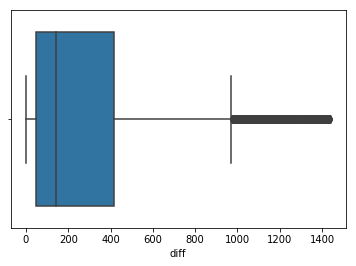

In [79]:
#rozklad czasu od pytania do pierwszej odpowiedzi (ograniczony do pierwszej doby)
sns.boxplot(first_answer_time_pandas[first_answer_time_pandas['diff']<60*24]['diff'])


In [36]:
#df_as1.join(df_as2, df_as1['Id'] == df_as2['ParentId'], 'inner').show()

AnalysisException: 'Detected implicit cartesian product for INNER join between logical plans\nProject [cast(Id#6 as int) AS Id#138, cast(PostTypeId#7 as int) AS PostTypeId#139, cast(ParentId#8 as int) AS ParentId#140, cast(CreationDate#10 as timestamp) AS CreationDate#142, cast(AnswerCount#23 as int) AS AnswerCount#141]\n+- Filter (((isnotnull(PostTypeId#7) && isnotnull(Id#6)) && isnotnull(ParentId#8)) && ((cast(PostTypeId#7 as int) = 1) && (cast(Id#6 as int) = cast(ParentId#8 as int))))\n   +- LogicalRDD [Id#6, PostTypeId#7, ParentId#8, AcceptedAnswerId#9, CreationDate#10, Score#11, ViewCount#12, Body#13, OwnerUserId#14, LastEditorUserId#15, LastEditorDisplayName#16, LastEditDate#17, LastActivityDate#18, CommunityOwnedDate#19, ClosedDate#20, Title#21, Tags#22, AnswerCount#23, CommentCount#24, FavoriteCount#25], false\nand\nAggregate [ParentId#379], [ParentId#379, min(CreationDate#380) AS min(CreationDate)#214]\n+- Project [cast(ParentId#8 as int) AS ParentId#379, cast(CreationDate#10 as timestamp) AS CreationDate#380]\n   +- Filter (isnotnull(PostTypeId#7) && (cast(PostTypeId#7 as int) = 2))\n      +- LogicalRDD [Id#6, PostTypeId#7, ParentId#8, AcceptedAnswerId#9, CreationDate#10, Score#11, ViewCount#12, Body#13, OwnerUserId#14, LastEditorUserId#15, LastEditorDisplayName#16, LastEditDate#17, LastActivityDate#18, CommunityOwnedDate#19, ClosedDate#20, Title#21, Tags#22, AnswerCount#23, CommentCount#24, FavoriteCount#25], false\nJoin condition is missing or trivial.\nEither: use the CROSS JOIN syntax to allow cartesian products between these\nrelations, or: enable implicit cartesian products by setting the configuration\nvariable spark.sql.crossJoin.enabled=true;'

In [26]:
df_as2

DataFrame[ParentId: int, min(CreationDate): timestamp]

# Data Exploration

## Badges

In [ ]:
tags.take(2)

In [ ]:
tags.sort('Count', ascending=False).show()

In [ ]:
import matplotlib
%matplotlib inline

In [ ]:
posts_time = posts.select([col('CreationDate').cast('date'), col('AnswerCount'), col('CommentCount')])

In [ ]:
posts_time.take(2)

In [ ]:
from pyspark.sql.functions import month, year
bitcoin_popularity = posts_time.groupBy(year('CreationDate')).count().toPandas()

In [ ]:
bitcoin_popularity.cumsum().plot()